In [ ]:
import warnings,sys,os
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import geohexgrid as ghg
import seaborn as sns
import shapely
from shapely import Point
import igraph as ig
from pathlib import Path
import matplotlib.pyplot as plt
import contextily as cx
import numpy as np
from matplotlib.colors import LinearSegmentedColormap,Normalize
from matplotlib.ticker import FuncFormatter, MultipleLocator
from matplotlib.patches import Rectangle,Patch
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1 import make_axes_locatable
import re
from exactextract import exact_extract
from matplotlib.lines import Line2D  # For custom legend
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import contextily as cx                                  
# Add project root to path
sys.path.append(str(Path().resolve().parent))
from src.simplify import *

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning) # exactextract gives a warning that is invalid

In [2]:
plt.rcParams['font.family'] = 'Calibri'

In [3]:
BASE_DIR = Path.cwd().parent
data_path = BASE_DIR / "input_files"
figure_path = BASE_DIR / "figures"

In [4]:
# =============================================================================
# 1. Load network and create graph
# =============================================================================
base_network = gpd.read_parquet(data_path / "base_network_SRB_basins.parquet")

edges = base_network.reindex(['from_id','to_id'] + [x for x in list(base_network.columns) if x not in ['from_id','to_id']], axis=1)
graph = ig.Graph.TupleList(edges.itertuples(index=False), edge_attrs=list(edges.columns)[2:], directed=True)
graph = graph.connected_components().giant()
edges = edges[edges['id'].isin(graph.es['id'])]

In [5]:
# path to the Statments population file
Path_StatementFile_Excel = data_path / "population_NEW_settlement_geocoded.xlsx"

# reading the Excel file
DataFrame_StatePop = pd.read_excel(Path_StatementFile_Excel)

# to keep only rows with valid coordinates and population
Clean_DataFrame_StatePop = DataFrame_StatePop.dropna(subset=["latitude", "longitude", "Total"])

# to make point geometry
geometry = [Point(xy) for xy in zip(Clean_DataFrame_StatePop["longitude"], Clean_DataFrame_StatePop["latitude"])]

# build GeoDataFrame matching df_worldpop structure
df_worldpop = gpd.GeoDataFrame(
    Clean_DataFrame_StatePop[["Total"]].rename(columns={"Total": "population"}),
    geometry=geometry,
    crs="EPSG:4326"  # longitude/latitude WGS84
)

# gdf is equivalent in structure to your df_worldpop
print(df_worldpop.head())

    population                   geometry
15      8967.0  POINT (20.42527 44.59395)
16      2044.0  POINT (20.37528 44.58539)
17       695.0   POINT (20.3954 44.51975)
18      1146.0   POINT (20.40044 44.5645)
19      1268.0  POINT (20.35048 44.53938)


In [6]:
vertex_lookup = dict(zip(pd.DataFrame(graph.vs['name'])[0], pd.DataFrame(graph.vs['name']).index))

tqdm.pandas()
from_id_geom = edges.geometry.progress_apply(lambda x: shapely.Point(x.coords[0]))
to_id_geom = edges.geometry.progress_apply(lambda x: shapely.Point(x.coords[-1]))

from_dict = dict(zip(edges['from_id'], from_id_geom))
to_dict = dict(zip(edges['to_id'], to_id_geom))

nodes = pd.concat([pd.DataFrame.from_dict(to_dict, orient='index', columns=['geometry']),
                   pd.DataFrame.from_dict(from_dict, orient='index', columns=['geometry'])]).drop_duplicates()

nodes['vertex_id'] = nodes.progress_apply(lambda x: vertex_lookup[x.name], axis=1)
nodes = nodes.reset_index()

nodes_sindex = shapely.STRtree(nodes.geometry)

df_worldpop['vertex_id'] = df_worldpop.geometry.progress_apply(lambda x: nodes.iloc[nodes_sindex.nearest(x)].vertex_id).values

100%|██████████| 4673/4673 [00:00<00:00, 11897.18it/s]


In [7]:
Sink = pd.read_excel(
    data_path / "4_Hospitals_healthcenters_geocoded.xlsx",
)

In [8]:
Sink['geometry'] = Sink.apply(lambda row: Point(row['Longitude'], row['Latitude']), axis=1)
Sink['vertex_id'] = Sink.geometry.apply(lambda x: nodes.iloc[nodes_sindex.nearest(x)].vertex_id).values

In [9]:
df_worldpop

,population,geometry,vertex_id
15,8967.0,POINT (20.42527 44.59395),110589
16,2044.0,POINT (20.37528 44.58539),145229
17,695.0,POINT (20.3954 44.51975),128566
18,1146.0,POINT (20.40044 44.5645),124404
19,1268.0,POINT (20.35048 44.53938),112495
...,...,...,...
5295,13.0,POINT (21.17119 43.10443),205115
5296,6.0,POINT (21.40045 42.90189),217936
5297,16.0,POINT (21.35782 42.92035),227691
5298,16.0,POINT (21.20877 43.09723),249044


In [10]:
# Get unique vertex IDs for both population and sinks
unique_pop_vertex_ids = df_worldpop['vertex_id'].unique()
unique_sink_vertex_ids = Sink['vertex_id'].unique()


In [11]:
def get_distance_to_nearest_facility(df_population, Sink, graph):
    """
    Optimized version using bulk distance matrix calculation with duplicate vertex_id handling
    """
    # Initialize new columns
    df_population = df_population.copy()
    df_population['closest_sink_vertex_id'] = None
    df_population['closest_sink_osm_id'] = None
    df_population['closest_sink_total_fft'] = None
    
    # Get unique vertex IDs for both population and sinks
    unique_pop_vertex_ids = df_population['vertex_id'].unique()
    unique_sink_vertex_ids = Sink['vertex_id'].unique()
    
    # Create mapping from unique sink vertex_ids back to original sink data
    sink_lookup = {}
    for _, row in Sink.iterrows():
        sink_lookup[row['vertex_id']] = row['i.d.']
    
    # Calculate distance matrix once for unique vertices only
    distance_matrix = np.array(graph.distances(
        source=unique_pop_vertex_ids,
        target=unique_sink_vertex_ids, 
        weights='fft'
    ))
    
    # Create lookup dictionary: vertex_id -> (closest_sink_vertex_id, closest_sink_osm_id, min_distance)
    vertex_to_closest_sink = {}
    
    for i, pop_vertex_id in enumerate(unique_pop_vertex_ids):
        # Get distances from this population point to all unique sinks
        distances_to_sinks = distance_matrix[i, :]
        
        # Find the index of the minimum distance
        min_sink_idx = np.argmin(distances_to_sinks)
        min_distance = distances_to_sinks[min_sink_idx]
        
        # Handle infinite distances (no path found)
        if np.isinf(min_distance):
            vertex_to_closest_sink[pop_vertex_id] = (None, None, float('inf'))
        else:
            closest_sink_vertex_id = unique_sink_vertex_ids[min_sink_idx]
            closest_sink_osm_id = sink_lookup[closest_sink_vertex_id]
            vertex_to_closest_sink[pop_vertex_id] = (
                closest_sink_vertex_id,
                closest_sink_osm_id, 
                min_distance
            )
    
    # Map results back to all population points (including duplicates)
    for idx, row in df_population.iterrows():
        vertex_id = row['vertex_id']
        closest_sink_vertex_id, closest_sink_osm_id, closest_sink_total_fft = vertex_to_closest_sink[vertex_id]
        
        df_population.at[idx, 'closest_sink_vertex_id'] = closest_sink_vertex_id
        df_population.at[idx, 'closest_sink_osm_id'] = closest_sink_osm_id
        df_population.at[idx, 'closest_sink_total_fft'] = closest_sink_total_fft
    
    return df_population

In [12]:
%%time
df_worldpop = get_distance_to_nearest_facility(df_worldpop,Sink,graph)

CPU times: total: 6min 26s
Wall time: 16h 9min 36s


In [13]:
df_worldpop

,population,geometry,vertex_id,closest_sink_vertex_id,closest_sink_osm_id,closest_sink_total_fft
15,8967.0,POINT (20.42527 44.59395),110589,6818,134,0.650448
16,2044.0,POINT (20.37528 44.58539),145229,6818,134,0.674428
17,695.0,POINT (20.3954 44.51975),128566,25572,109,0.736722
18,1146.0,POINT (20.40044 44.5645),124404,6818,134,0.778273
19,1268.0,POINT (20.35048 44.53938),112495,25572,109,0.76555
...,...,...,...,...,...,...
5295,13.0,POINT (21.17119 43.10443),205115,206840,90,0.183679
5296,6.0,POINT (21.40045 42.90189),217936,188803,96,0.816611
5297,16.0,POINT (21.35782 42.92035),227691,206840,90,0.5348
5298,16.0,POINT (21.20877 43.09723),249044,206840,90,0.119684


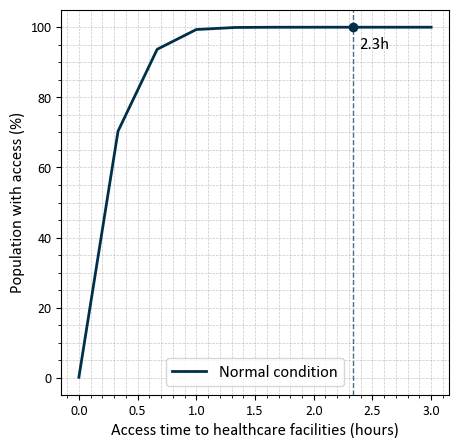

In [14]:
fig, ax_curve = plt.subplots(1, 1, figsize=(5, 5))


# Panel B: Calculate access curves
None_INF_Pop_in_Zone_Sample = df_worldpop.copy()
total_population = df_worldpop['population'].sum()
thresholds = np.arange(0, 3.1, 1/3)  

percentage_population_within_threshold_2 = []


for threshold in thresholds:
    population_sum_2 = df_worldpop.loc[
        df_worldpop['closest_sink_total_fft'] <= threshold, 'population'
    ].sum()
    population_percentage_2 = (population_sum_2 / total_population) * 100
    percentage_population_within_threshold_2.append(population_percentage_2)

# Find 100% thresholds
threshold_100_2 = next((threshold for i, threshold in enumerate(thresholds) 
                       if percentage_population_within_threshold_2[i] == 100), None)

# Plot access curves
ax_curve.plot(thresholds, percentage_population_within_threshold_2, linestyle='-', 
             color='#003049', linewidth=2, label='Normal condition')

ax_curve.set_xlabel('Access time to healthcare facilities (hours)', fontsize=12)
ax_curve.set_ylabel('Population with access (%)', fontsize=12)
ax_curve.legend(fontsize=12)
ax_curve.minorticks_on()
ax_curve.grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Match Panel A's height by setting aspect ratio
ax_curve.set_aspect('auto', adjustable='box')

if threshold_100_2 is not None:
    ax_curve.axvline(x=threshold_100_2, color='#003049', linestyle='--', linewidth=1, alpha=0.7)
    ax_curve.plot(threshold_100_2, 100, 'o', color='#003049', markersize=6)
    ax_curve.text(threshold_100_2+0.05, 94, f'{threshold_100_2:.1f}h', color='black', ha='left', fontsize=12)

plt.savefig(figure_path / 'baseline_accessibility_disruptions.png',dpi=150,transparent=True)

In [15]:
threshold_100_2

np.float64(2.333333333333333)

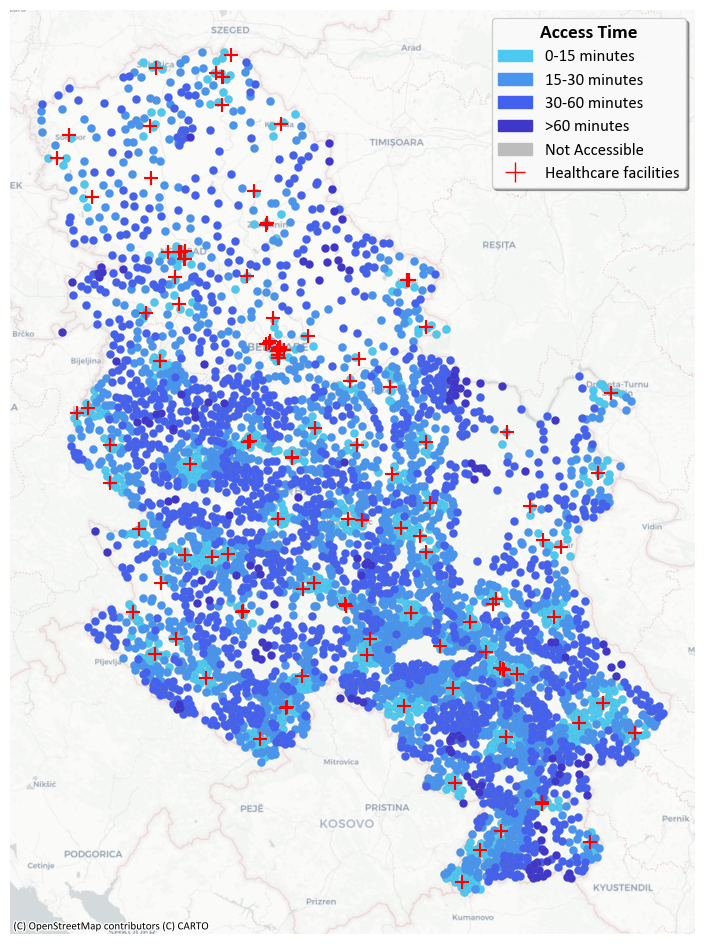

In [16]:
import matplotlib.patches as mpatches

# Prepare data
edges_gdf = gpd.GeoDataFrame(edges, geometry='geometry')
df_worldpop_plot = gpd.GeoDataFrame(df_worldpop, geometry='geometry', crs="EPSG:4326").to_crs(3857)
Sink_health = gpd.GeoDataFrame(Sink, geometry='geometry', crs="EPSG:4326").to_crs(3857)

# Create bins for categories (1-hour intervals)
bins = [0, 0.25, 0.5, 1, float('inf')]
labels = ['0-15', '15-30', '30-60', '>60']
colors = ['#4cc9f0','#4895ef', '#4361ee', '#3f37c9', '#3a0ca3']

# Assign categories
df_worldpop_plot['category'] = pd.cut(df_worldpop_plot['closest_sink_total_fft'], 
                                       bins=bins, labels=labels, right=False)

# Convert to object type to allow mixed values
df_worldpop_plot['category'] = df_worldpop_plot['category'].astype('object')

# Handle NaN values as "Not Accessible"
df_worldpop_plot.loc[df_worldpop_plot['category'].isna(), 'category'] = 'Not Accessible'

# Add "Not Accessible" to color mapping (using gray)
color_map = dict(zip(labels, colors))
color_map['Not Accessible'] = '#bdbdbd'  # Gray color

# Create figure
fig, ax = plt.subplots(figsize=(18, 12))

# Plot by category
for category, color in color_map.items():
    data = df_worldpop_plot[df_worldpop_plot['category'] == category]
    if not data.empty:
        data.plot(ax=ax, color=color, legend=False,linewidth=0.1,edgecolor='grey')

Sink_health.plot(ax=ax, color='red', markersize=100, marker='+')
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)

# Enhance the plot styling
ax.set_aspect('equal')
ax.axis('off')  # Remove axis for cleaner look

# Create legend patches (add "Not Accessible" at the end)
legend_patches = [mpatches.Patch(color=color, label=f'{label} minutes') 
                  for label, color in zip(labels, colors)]
legend_patches.append(mpatches.Patch(color='#bdbdbd', label='Not Accessible'))
legend_patches.append(Line2D([0], [0], marker='+', color='red', lw=0, 
                             label='Healthcare facilities', markersize=15))

# Add legend
legend  = ax.legend(handles=legend_patches, 
          loc='upper right',
          fontsize=12,
          title='Access Time',
          title_fontsize=14,
          frameon=True,
          fancybox=True,
          shadow=True,
          framealpha=0.95)

legend.get_title().set_fontweight('bold')

plt.savefig(figure_path / 'hospital_access.png', dpi=200, bbox_inches='tight')


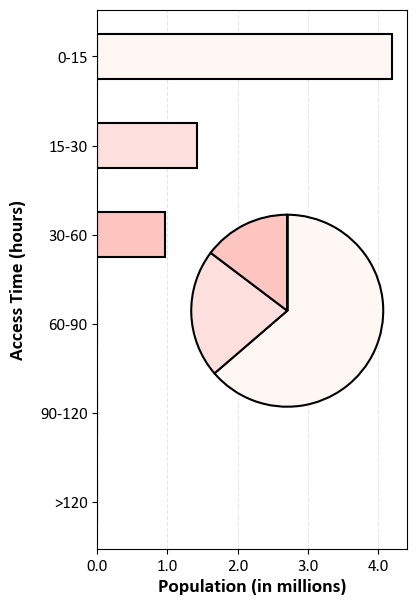

In [17]:
# Calculate total population per category
pop_by_category = df_worldpop_plot.groupby('category')['population'].sum()/1e6

# Define the order of categories and their colors
category_order = ['0-15', '15-30', '30-60', '60-90', '90-120', '>120']
category_colors = ['#fff7f3', '#fde0dd', '#fcc5c0', '#fa9fb5', '#f768a1', '#c51b8a', '#bdbdbd']
color_dict = dict(zip(category_order, category_colors))

# Reindex to ensure all categories are present and in correct order
pop_by_category = pop_by_category.reindex(category_order, fill_value=0)

# Reverse order for horizontal plot (so 0-0.5 is at top)
pop_by_category_reversed = pop_by_category[::-1]

# Create the plot
fig, ax = plt.subplots(figsize=(4, 7))

# Create horizontal bar chart with narrower bars
bars = ax.barh(range(len(pop_by_category_reversed)), pop_by_category_reversed.values, 
               height=0.5,
               color=[color_dict[cat] for cat in pop_by_category_reversed.index],
               edgecolor='black', linewidth=1.5)

# Customize the plot
ax.set_ylabel('Access Time (hours)', fontsize=14, fontweight='bold', labelpad=10)
ax.set_xlabel('Population (in millions)', fontsize=14, fontweight='bold')

# Set y-axis labels
ax.set_yticks(range(len(pop_by_category_reversed)))
ax.set_yticklabels(pop_by_category_reversed.index, fontsize=12)

# Format x-axis with thousands separator
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.1f}'))
ax.tick_params(axis='x', labelsize=12)

# Add grid for better readability
ax.grid(axis='x', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

# Create inset pie chart
ax_inset = fig.add_axes([0.3, 0.15, 0.6, 0.6])  # [left, bottom, width, height]

# Pie chart with same order as original (not reversed) and matching colors
pie_colors = [color_dict[cat] for cat in pop_by_category.index]
wedges, texts = ax_inset.pie(pop_by_category.values, 
                               colors=pie_colors,
                               startangle=90,
                               counterclock=False,
                               wedgeprops={'edgecolor': 'black', 'linewidth': 1.5})